In [86]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrices
from tableone import TableOne
wd = '/Volumes/PEDS/RI Biostatistics Core/Shared/Shared Projects/Laura/BDC/Projects/Viral Shah/Day and Night CGM/'
sns.set_theme(style="whitegrid")
sns.set_palette("coolwarm")

In [87]:
# Import data
df = pd.read_csv(wd+'Data_Clean/analysis_data.csv',usecols=['ID','Age','HbA1c',
"14 Day Mean","14 Day TIR 70 - 140","14 Day TIR 70 - 180","14 Day TIR Over 180",
"14 Night Mean","14 Night TIR 70 - 140","14 Night TIR 70 - 180","14 Night TIR Over 180"])
df.columns = ['id','age','a1c','day_mbg','day_tir_70_140','day_tir_70_180','day_tir_over_180',
'night_mbg',"night_tir_70_140","night_tir_70_180","night_tir_over_180"]
# Get row with most sensor values for each person in JDRF data
jdrf = pd.read_csv(wd+'Data_Clean/analysis_data_jdrf.csv')
idx = jdrf.groupby('id',sort=False)['sensor_readings'].transform(max) == jdrf['sensor_readings']
jdrf = jdrf[idx]
idx = jdrf["sensor_readings"] >= 2822 # 70% cutoff for 2 weeks of data
jdrf = jdrf[idx]
# Combine
jdrf = jdrf[['id','age','a1c','day_mbg','day_tir_70_140','day_tir_70_180','day_tir_over_180',
'night_mbg',"night_tir_70_140","night_tir_70_180","night_tir_over_180"]]
df = pd.concat([df,jdrf])
df.reset_index(inplace=True,drop=True)

In [88]:
# Demographics
kaan_demo = pd.read_csv(wd+"Data_Clean/demographics.csv",
                        usecols=["FirstName","LastName","Age","Gender",
                                 "DiabetesDuration_MostRecentVisitDate",
                                 "BMI","Hemoglobin_Value","MCV_Value","eGFR_Value",
                                 "Retinopathy_OD","Retinopathy_OS",
                                 "Hypothyroidism_YesNo","Hyperthyroidism_YesNo",	
                                 "GravesDisease_YesNo","CeliacDisease_YesNo",
                                 "AddisonsDisease_YesNo"])
kaan_demo["id"] = pd.Series([n.lower() for n in kaan_demo["FirstName"]])\
    + "_" + pd.Series([n.lower() for n in kaan_demo["LastName"]])
# Manually fixed some names:
# tomas_delong
# carrie_kroll
# ryan_bennett2
# joshua_shelton
# cortney _fernandez de castro
# conner_mckern
# josh_kamin
# kaelen_davis
# cathy_krendl
# kelli_kinkaid
# charlie_bevis
# susan michelle_clay
# lynell_rice-brinkworth
# ed_wiley
# Variables:
# age, sex, diabetes duration, BMI, mean A1c, mean HB, mean egfr, mean eGFR, 
# % of patients with retinopathy (any type, categorical variable), 
# % of patients with autoimmune disease (combine hypothyroidism, 
# hyperthyroidism, Graves, Celiac and Addison-If yes, autoimmune disease present)
# Sort out data
# Combine categorical variables
kaan_demo["Autoimmune Disease?"] = \
    kaan_demo[["Hypothyroidism_YesNo","Hyperthyroidism_YesNo",	
               "GravesDisease_YesNo","CeliacDisease_YesNo",
               "AddisonsDisease_YesNo"]].replace(["No","Yes"],[0,1])\
        .sum(axis=1).replace([0,1,2],["No","Yes","Yes"])
# Retinopathy in either eye?
kaan_demo["Retinopathy_OD"] = kaan_demo["Retinopathy_OD"].str.strip() 
kaan_demo["Retinopathy_OS"] = kaan_demo["Retinopathy_OS"].str.strip() 
ret_values = kaan_demo["Retinopathy_OD"].tolist() + kaan_demo["Retinopathy_OS"].tolist()
ret_values = list(set([v for v in ret_values if str(v) != "nan"]))
ret_values = dict.fromkeys(ret_values,1)
ret_values["No Retinopathy"] = 0
kaan_demo["Retinopathy?"] = kaan_demo[["Retinopathy_OD","Retinopathy_OS"]]\
    .replace(ret_values).sum(axis=1,skipna=False).replace({0:"No",1:"Yes",2:"Yes"})


In [89]:
# JDRF demographics - manually changed column names to match Kaan's data
jdrf_demo = pd.read_csv(wd+"Data_Clean/jdrf_demographics.csv",
                        usecols=["id","FirstName","LastName","MRN","Age","Gender",
                                 "DiabetesDuration_MostRecentVisitDate",
                                 "BMI","Retinopathy_OD","Retinopathy_OS",
                                 "Hypothyroidism_YesNo","Hyperthyroidism_YesNo",	
                                 "GravesDisease_YesNo","CeliacDisease_YesNo",
                                 "AddisonsDisease_YesNo"])
# JDRF labs
jdrf_mcv = pd.read_excel(wd + "Data_Clean/jdrf_labs.xlsx",sheet_name='MCV')
jdrf_hb = pd.read_excel(wd + "Data_Clean/jdrf_labs.xlsx",sheet_name='Hemoglobin')
jdrf_egfr = pd.read_excel(wd + "Data_Clean/jdrf_labs.xlsx",sheet_name='eGFR')
# Get most recent values
jdrf_hb['Time'] = abs(jdrf_hb['ResultDate'] - jdrf_hb['Date of eye exam'])
jdrf_hb = jdrf_hb.groupby('MRN').apply(lambda x: x[x['Time'] == x['Time'].min()])
jdrf_hb = jdrf_hb[['MRN','OrderValue']]
jdrf_hb.columns = ['MRN','Hemoglobin_Value']
jdrf_hb = jdrf_hb.reset_index(drop = True).drop_duplicates()
jdrf_mcv['Time'] = abs(jdrf_mcv['ResultDate'] - jdrf_mcv['Date of eye exam'])
jdrf_mcv = jdrf_mcv.groupby('MRN').apply(lambda x: x[x['Time'] == x['Time'].min()])
jdrf_mcv = jdrf_mcv[['MRN','OrderValue']]
jdrf_mcv.columns = ['MRN','MCV_Value']
jdrf_mcv = jdrf_mcv.reset_index(drop = True).drop_duplicates()
jdrf_egfr['Time'] = abs(jdrf_egfr['ResultDate'] - jdrf_egfr['Date of eye exam'])
jdrf_egfr = jdrf_egfr.groupby('MRN').apply(lambda x: x[x['Time'] == x['Time'].min()])
jdrf_egfr = jdrf_egfr[jdrf_egfr['LabComponent'].isin(['EGFR NON-AFR. AMERICAN','EGFR IF NONAFRICN AM'])]
jdrf_egfr = jdrf_egfr[['MRN','OrderValue']]
jdrf_egfr.columns = ['MRN','eGFR_Value']
jdrf_egfr = jdrf_egfr.reset_index(drop = True).drop_duplicates()
# Merge with demographics
jdrf_demo = pd.merge(jdrf_demo,jdrf_hb,on='MRN',how='outer')
jdrf_demo = pd.merge(jdrf_demo,jdrf_mcv,on='MRN',how='outer')
jdrf_demo = pd.merge(jdrf_demo,jdrf_egfr,on='MRN',how='outer')
# Combine categorical variables
jdrf_demo["Autoimmune Disease?"] = \
    jdrf_demo[["Hypothyroidism_YesNo","Hyperthyroidism_YesNo",	
           "GravesDisease_YesNo","CeliacDisease_YesNo",
           "AddisonsDisease_YesNo"]].replace(["No","Yes"],[0,1])\
               .sum(axis=1).replace([0,1,2],["No","Yes","Yes"])
# Retinopathy in either eye?
jdrf_demo["Retinopathy_OD"] = jdrf_demo["Retinopathy_OD"].str.strip() 
jdrf_demo["Retinopathy_OS"] = jdrf_demo["Retinopathy_OS"].str.strip() 
ret_values = jdrf_demo["Retinopathy_OD"].tolist() + jdrf_demo["Retinopathy_OS"].tolist()
ret_values = list(set([v for v in ret_values if str(v) != "nan"]))
ret_values = dict.fromkeys(ret_values,1)
ret_values["No Retinopathy"] = 0
jdrf_demo["Retinopathy?"] = jdrf_demo[["Retinopathy_OD","Retinopathy_OS"]]\
    .replace(ret_values).sum(axis=1,skipna=False).replace({0:"No",1:"Yes",2:"Yes"})
# Put everything together
demo = pd.concat([jdrf_demo,kaan_demo])
df = pd.merge(df,demo,how='left',on='id')
# As numeric
df['Hemoglobin_Value'] = pd.to_numeric(df['Hemoglobin_Value'],errors='coerce')
df['MCV_Value'] = pd.to_numeric(df['MCV_Value'],errors='coerce')
df['eGFR_Value'] = pd.to_numeric(df['eGFR_Value'],errors='coerce')

# Data Characteristics
- TIR was calculated using 2 weeks of CGM data prior to an office visit.
- For participants with multiple HbA1c measures, the CGM wear with the largest number of sensor readings was used. This was done to prevent auto-correlation between measures within a subject.
- CGM with < 70% wear were excluded.

In [90]:
# Split into HbA1c groups
df['a1c_group'] = pd.cut(df['a1c'],[0,7,8,9,10,float('inf')],labels = ["<7%","[7.0%, 8.0%)","[8.0%, 9.0%)","[9.0%, 10.0%)",">10%"],right=False)
# Difference between day and night
df['tir_70_140_diff'] = df['day_tir_70_140'] - df['night_tir_70_140']
df['tir_70_180_diff'] = df['day_tir_70_180'] - df['night_tir_70_180']
df['tir_over_180_diff'] = df['day_tir_over_180'] - df['night_tir_over_180']
df['mbg_diff'] = df['day_mbg'] - df['night_mbg']

# Participant Characteristics

In [91]:
columns = ['a1c','Age','Gender', 'BMI', 'DiabetesDuration_MostRecentVisitDate','Hemoglobin_Value','MCV_Value', 'eGFR_Value', 'Autoimmune Disease?', 'Retinopathy?']
categorical = ['Gender','Autoimmune Disease?', 'Retinopathy?']
group = ['a1c_group']
TableOne(df, columns, categorical,groupby = group)

Grouped by a1c_group                                                                                
                                                                 Missing      Overall          <7% [7.0%, 8.0%) [8.0%, 9.0%) [9.0%, 10.0%)          >10%
n                                                                                 407          190          124           48            26            19
a1c, mean (SD)                                                         0    7.3 (1.4)    6.3 (0.5)    7.4 (0.3)    8.3 (0.3)     9.4 (0.3)    11.4 (0.9)
Age, mean (SD)                                                        60  38.7 (14.6)  40.4 (13.0)  40.8 (15.1)  33.9 (15.9)   35.1 (16.0)   25.6 (11.9)
Gender, n (%)                                   F                     60   192 (55.3)    91 (55.8)    52 (49.5)    28 (68.3)     12 (60.0)      9 (50.0)
                                                M                          155 (44.7)    72 (44.2)    53 (50.5)    13 (31.7)      8 (40.0)      9 (50.0)
BMI, mean (SD)                                                        73   26.7 (4.7)   26.6 (4.5)   27.8 (5.2)   25.5 (3.9)    25.2 (3.7)    24.0 (4.9)
DiabetesDuration_MostRecentVisitDate, mean (SD)                       62  19.7 (13.0)  20.2 (13.2)  20.5 (13.2)  19.1 (12.6)   19.2 (13.7)    12.7 (8.0)
Hemoglobin_Value, mean (SD)                                          134   15.0 (1.5)   14.9 (1.5)   15.0 (1.6)   14.9 (1.1)    15.2 (1.4)    15.6 (1.6)
MCV_Value, mean (SD)                                                 174   90.5 (4.5)   90.8 (4.7)   90.0 (4.3)   90.8 (5.1)    89.2 (2.4)    92.3 (4.1)
eGFR_Value, mean (SD)                                                131  97.7 (18.6)  97.0 (18.8)  95.6 (17.8)  97.5 (19.1)  111.6 (12.1)  107.1 (20.7)
Autoimmune Disease?, n (%)                      No                    60   270 (77.8)   130 (79.8)    81 (77.1)    31 (75.6)     14 (70.0)     14 (77.8)
                                                Yes                         77 (22.2)    33 (20.2)    24 (22.9)    10 (24.4)      6 (30.0)      4 (22.2)
Retinopathy?, n (%)                             No                   119   108 (37.5)    58 (43.9)    31 (34.4)     9 (24.3)      6 (40.0)      4 (28.6)
                                                Yes                        180 (62.5)    74 (56.1)    59 (65.6)    28 (75.7)      9 (60.0)     10 (71.4)

## Summary Table and Variable Distributions

In [92]:
columns = ['age','a1c','day_mbg','day_tir_70_140','day_tir_70_180','day_tir_over_180',
'night_mbg',"night_tir_70_140","night_tir_70_180","night_tir_over_180"]
group = ['a1c_group']
TableOne(df, columns, groupby = group)

Grouped by a1c_group                                                                                    
                                            Missing       Overall           <7%  [7.0%, 8.0%)  [8.0%, 9.0%) [9.0%, 10.0%)          >10%
n                                                             407           190           124            48            26            19
age, mean (SD)                                    0   38.7 (15.0)   40.7 (13.5)   41.5 (15.5)   32.7 (15.3)   32.0 (15.3)   24.7 (12.0)
a1c, mean (SD)                                    0     7.3 (1.4)     6.3 (0.5)     7.4 (0.3)     8.3 (0.3)     9.4 (0.3)    11.4 (0.9)
day_mbg, mean (SD)                                0  167.0 (35.6)  143.2 (22.7)  171.4 (17.3)  193.4 (19.4)  214.9 (28.8)  244.0 (39.0)
day_tir_70_140, mean (SD)                         0   38.9 (17.4)   51.1 (14.7)    33.8 (9.8)    24.7 (8.0)    18.9 (9.2)    13.2 (9.2)
day_tir_70_180, mean (SD)                         0   60.5 (19.0)   73.5 (12.6)   57.4 (11.3)   45.7 (10.6)   35.0 (14.3)   23.5 (13.6)
day_tir_over_180, mean (SD)                       0   36.4 (20.4)   22.2 (13.8)   40.3 (11.7)   52.7 (11.0)   63.8 (14.6)   75.3 (14.7)
night_mbg, mean (SD)                              0  168.7 (40.4)  143.6 (25.0)  175.3 (28.8)  195.3 (29.5)  219.7 (36.1)  239.9 (50.9)
night_tir_70_140, mean (SD)                       0   39.0 (20.0)   51.1 (17.2)   33.5 (15.7)   25.5 (13.2)   19.1 (13.3)   14.9 (10.1)
night_tir_70_180, mean (SD)                       0   59.1 (21.8)   72.5 (15.0)   54.9 (18.4)   43.3 (16.1)   34.0 (17.7)   27.6 (16.8)
night_tir_over_180, mean (SD)                     0   37.5 (23.2)   22.7 (15.8)   42.6 (19.2)   54.9 (16.4)   64.2 (18.3)   70.4 (18.5)

## Mean Day and Night TIR

### By HbA1c Group

#### TIR

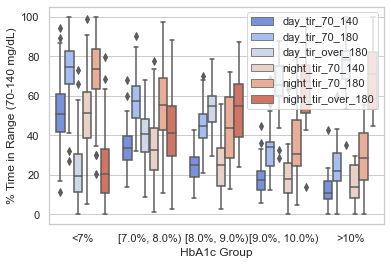

In [93]:
# Wide to long
plot_df = df.melt(id_vars=['a1c','a1c_group'],value_vars=['day_tir_70_140','day_tir_70_180','day_tir_over_180',
"night_tir_70_140","night_tir_70_180","night_tir_over_180"], value_name='TIR')
plot_df['variable'].replace({'day_tir':'Day','night_tir':'Night'},inplace=True)
# Plot
plot = sns.boxplot(x='a1c_group',y='TIR',hue='variable',data=plot_df)
plot.set(xlabel='HbA1c Group',ylabel='% Time in Range (70-140 mg/dL)')
plot.legend(title='');

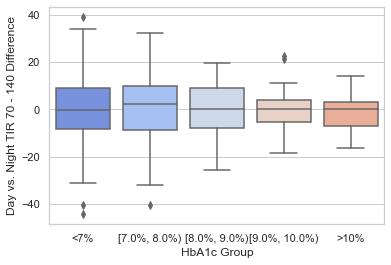

In [94]:
plot = sns.boxplot(x='a1c_group',y='tir_70_140_diff',data=df)
plot.set(xlabel='HbA1c Group',ylabel='Day vs. Night TIR 70 - 140 Difference');

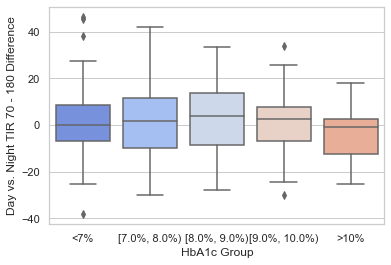

In [95]:
plot = sns.boxplot(x='a1c_group',y='tir_70_180_diff',data=df)
plot.set(xlabel='HbA1c Group',ylabel='Day vs. Night TIR 70 - 180 Difference');

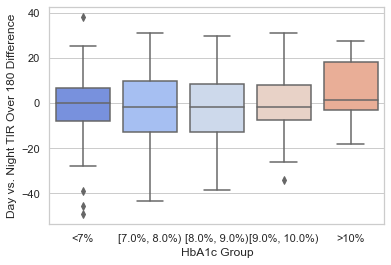

In [96]:
plot = sns.boxplot(x='a1c_group',y='tir_over_180_diff',data=df)
plot.set(xlabel='HbA1c Group',ylabel='Day vs. Night TIR Over 180 Difference');

#### Mean Sensor Glucose

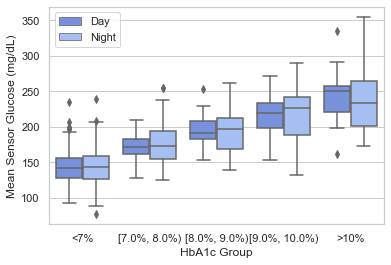

In [97]:
# Wide to long
plot_df = df.melt(id_vars=['a1c','a1c_group'],value_vars=['day_mbg','night_mbg'], value_name='MSG')
plot_df['variable'].replace({'day_mbg':'Day','night_mbg':'Night'},inplace=True)
# Plot
plot = sns.boxplot(x='a1c_group',y='MSG',hue='variable',data=plot_df)
plot.set(xlabel='HbA1c Group',ylabel='Mean Sensor Glucose (mg/dL)')
plot.legend(title='');

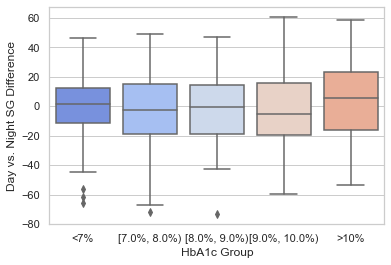

In [98]:
plot = sns.boxplot(x='a1c_group',y='mbg_diff',data=df)
plot.set(xlabel='HbA1c Group',ylabel='Day vs. Night SG Difference');

Error bars indicate 95% confidence interval around the mean.

In [99]:
# Tests
lm = smf.ols('day_mbg ~ a1c_group',data=df).fit()
sm.stats.anova_lm(lm, typ=2)


,sum_sq,df,F,PR(>F)
a1c_group,315884.310721,4.0,158.82489,2.220638e-81
Residual,199882.859587,402.0,NaN,NaN


There were significant differences in day time mean sensor glucose between HbA1c group (p < 0.001).

In [100]:
lm = smf.ols('night_mbg ~ a1c_group',data=df).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
a1c_group,323099.683925,4.0,95.613638,4.334397e-57
Residual,339611.784013,402.0,NaN,NaN


There were significant differences in night time mean sensor glucose between HbA1c group (p < 0.001).

In [101]:
lm = smf.ols('day_tir_70_140 ~ a1c_group',data=df).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
a1c_group,63886.650626,4.0,107.845559,2.404988e-62
Residual,59535.213461,402.0,NaN,NaN


There were significant differences in day time TIR 70 - 140 between HbA1c group (p < 0.001).

In [102]:
lm = smf.ols('day_tir_70_180 ~ a1c_group',data=df).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
a1c_group,86886.499376,4.0,146.638569,3.423437e-77
Residual,59548.406903,402.0,NaN,NaN


There were significant differences in day time TIR 70 - 180 between HbA1c group (p < 0.001).

In [103]:
lm = smf.ols('day_tir_over_180 ~ a1c_group',data=df).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
a1c_group,101470.144177,4.0,150.463857,1.578109e-78
Residual,67775.409128,402.0,NaN,NaN


There were significant differences in day time TIR over 180 between HbA1c group (p < 0.001).

In [104]:
lm = smf.ols('night_tir_70_140 ~ a1c_group',data=df).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
a1c_group,61683.936090,4.0,61.434908,1.761453e-40
Residual,100907.379481,402.0,NaN,NaN


There were significant differences in night time TIR 70 - 140 between HbA1c group (p < 0.001).

In [105]:
lm = smf.ols('night_tir_70_180 ~ a1c_group',data=df).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
a1c_group,83610.519313,4.0,76.658721,2.876527e-48
Residual,109613.845092,402.0,NaN,NaN


There were significant differences in night time TIR 70 - 180 between HbA1c group (p < 0.001).

In [106]:
lm = smf.ols('night_tir_over_180 ~ a1c_group',data=df).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
a1c_group,98261.462699,4.0,82.4009,4.916724e-51
Residual,119844.285437,402.0,NaN,NaN


There were significant differences in night time TIR over 180 between HbA1c group (p < 0.001).

In [107]:
lm = smf.ols('mbg_diff ~ a1c_group',data=df).fit()
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
a1c_group,4.0,1784.493140,446.123285,0.880513,0.475538
Residual,402.0,203678.522865,506.662992,NaN,NaN


The difference between day and night MSG was not different between HbA1c groups (p = 0.48).

In [108]:
lm = smf.ols('tir_70_140_diff ~ a1c_group',data=df).fit()
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
a1c_group,4.0,97.066521,24.266630,0.147425,0.964088
Residual,402.0,66170.425656,164.603049,NaN,NaN


The difference between day and night TIR 70 - 140 was not different between HbA1c groups (p = 0.96).

In [109]:
lm = smf.ols('tir_70_180_diff ~ a1c_group',data=df).fit()
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
a1c_group,4.0,805.531964,201.382991,1.118377,0.347336
Residual,402.0,72386.995488,180.067153,NaN,NaN


The difference between day and night TIR 70 - 180 was not different between HbA1c groups (p = 0.35).

In [110]:
lm = smf.ols('tir_over_180_diff ~ a1c_group',data=df).fit()
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
a1c_group,4.0,1010.480519,252.620130,1.287209,0.274331
Residual,402.0,78894.159856,196.254129,NaN,NaN


The difference between day and night TIR over 180 was not different between HbA1c groups (p = 0.27).

## Correlations Between All Variables

### Full Cohort

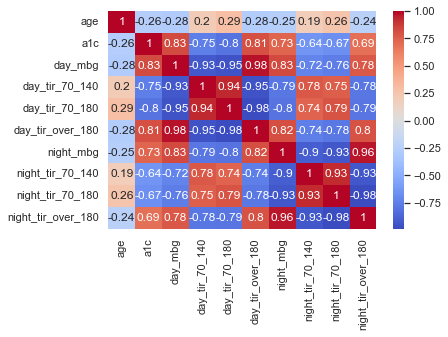

In [111]:
corr_mat = df[['age','a1c','a1c_group','day_mbg','day_tir_70_140','day_tir_70_180','day_tir_over_180',
'night_mbg',"night_tir_70_140","night_tir_70_180","night_tir_over_180"]]
c_full = corr_mat.corr()
sns.heatmap(c_full,annot=True,cmap="coolwarm");

In [112]:
corr_mat.corr()

,age,a1c,day_mbg,day_tir_70_140,day_tir_70_180,day_tir_over_180,night_mbg,night_tir_70_140,night_tir_70_180,night_tir_over_180
age,1.000000,-0.261915,-0.284652,0.202789,0.288505,-0.275325,-0.253977,0.192688,0.256533,-0.238161
a1c,-0.261915,1.000000,0.827341,-0.750321,-0.799465,0.809046,0.734826,-0.637071,-0.671141,0.687698
day_mbg,-0.284652,0.827341,1.000000,-0.926318,-0.950582,0.976228,0.832148,-0.724022,-0.755324,0.781545
day_tir_70_140,0.202789,-0.750321,-0.926318,1.000000,0.935428,-0.953732,-0.787201,0.775614,0.754807,-0.784098
day_tir_70_180,0.288505,-0.799465,-0.950582,0.935428,1.000000,-0.984785,-0.802856,0.738704,0.792063,-0.793977
day_tir_over_180,-0.275325,0.809046,0.976228,-0.953732,-0.984785,1.000000,0.815149,-0.744730,-0.779417,0.800106
night_mbg,-0.253977,0.734826,0.832148,-0.787201,-0.802856,0.815149,1.000000,-0.901678,-0.930683,0.961302
night_tir_70_140,0.192688,-0.637071,-0.724022,0.775614,0.738704,-0.744730,-0.901678,1.000000,0.926898,-0.934558
night_tir_70_180,0.256533,-0.671141,-0.755324,0.754807,0.792063,-0.779417,-0.930683,0.926898,1.000000,-0.981853
night_tir_over_180,-0.238161,0.687698,0.781545,-0.784098,-0.793977,0.800106,0.961302,-0.934558,-0.981853,1.000000
